# Import Library

In [1]:
import numpy as np
import math
import natsort
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

# Data Loder

In [2]:
def sortlist(filelist):
    filelist = natsort.natsorted(filelist)
    return filelist

In [3]:
dir_path = os.getenv("HOME")+ '/Cloud_data/cloud_train/'

In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose,VerticalFlip,ShiftScaleRotate,RandomBrightnessContrast

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    VerticalFlip(p=0.5),      # 50%의 확률로 상하대칭
                    ])
  else:
    return Compose([ ])

augmentation = build_augmentation()
not_augmentation = build_augmentation(is_train = False)

In [5]:
class CloudGenerator(Sequence):
    def __init__(self,
                 dir_path,
                 batch_size = 4,
                 img_size = (800,800,3),
                 output_size = (800,800,4), # WxHxC ( C == num_class )
                 is_train = True,
                 augmentation=None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.is_train = is_train
        self.augmentation = augmentation
        
        self.data = self.load_dataset()
    
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path,"patch_img800","*png"))
        label_images = glob(os.path.join(self.dir_path,"patch_labeling800","*png"))

        input_images = sortlist(input_images)
        label_images = sortlist(label_images)
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        
        train_percent = int(len(data) * 0.8)

        if self.is_train:
            return data[:train_percent]
        return data[train_percent:]

    def __getitem__(self, index):
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        outputs_mini = np.zeros([*self.output_size])
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = cv2.imread(input_img_path)
            _output = cv2.imread(output_path,0)
            
            _output1 = (_output == 50).astype(np.uint8)*1
            _output2 = (_output == 30).astype(np.uint8)*1
            _output3 = (_output == 10).astype(np.uint8)*1
            _output4 = (_output == 0).astype(np.uint8)*1
            
            outputs_mini[:,:,0] = _output1  # Thick Cloud  : 1
            outputs_mini[:,:,1] = _output2  # Thin Cloud   : 2
            outputs_mini[:,:,2] = _output3  # Cloud shadow : 3
            outputs_mini[:,:,3] = _output4  # Ground : 0
            
#             augmented = self.augmentation(image=_input)
                
            data = {
                      "image": _input,
                      "mask": outputs_mini,
                   }
            
            augmented = self.augmentation(**data)
            
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
     
            return inputs, outputs

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [6]:
train_generator = CloudGenerator(
    dir_path,
    is_train=True,
    augmentation = augmentation
)

test_generator = CloudGenerator(
    dir_path,
    is_train=False,
    augmentation = not_augmentation
)

In [7]:
# np.set_printoptions(threshold=1000)

In [8]:
# train_generator.__getitem__(3)

# Build Atrous U-Net Model

In [9]:
def atrous_unet_encoder(x, channel = 64, kernel_size = (3,3), strides=1,activation='relu'):
    skip_connection = []
    for i in range(4):
        x = Conv2D(channel* 2**i, kernel_size, activation=activation, padding='same',kernel_initializer='he_normal')(x)
        x = Conv2D(channel* 2**i, kernel_size, activation=activation, padding='same',kernel_initializer='he_normal')(x)
        skip_connection.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    return x, skip_connection

def atrous_unet_bottleneck(x,kernel_size = (3,3),activation='relu'):
    for i in range(6):
        x = Conv2D(1024, kernel_size, activation=activation, padding='same',dilation_rate=(2**i, 2**i),kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    return x

def atrous_unet_decoder(x,skip_connection,channel = 64, kernel_size = (3,3),activation = 'relu'):
    for i in reversed(range(4)):
        x = Conv2DTranspose(channel* 2**i, 2, strides = (2,2), activation=activation,kernel_initializer='he_normal')(x)
        x = concatenate([skip_connection[i],x],axis =3)
        x = Conv2D(channel* 2**i, kernel_size, activation=activation, padding='same',kernel_initializer='he_normal')(x)
        x = Conv2D(channel* 2**i, kernel_size, activation=activation, padding='same',kernel_initializer='he_normal')(x)
    return x

def atrous_unet_model(input_shape=(800,800,3)):
    input = Input(input_shape)
    encoder,skip = atrous_unet_encoder(input)
    bottleneck = atrous_unet_bottleneck(encoder)
    decoder = atrous_unet_decoder(bottleneck,skip)
    output = Conv2D(4, 1, activation = 'softmax')(decoder)     # num_class = 4
    Atrous_unet_model = Model(inputs = input,outputs = output)

    return Atrous_unet_model

In [10]:
Atrous_unet_model = atrous_unet_model()
Atrous_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 800, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 800, 800, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 400, 400, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
Atrous_unet_model = atrous_unet_model()
Atrous_unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy',metrics = ['accuracy'])

with tf.device("/device:GPU:0"):
    hist = Atrous_unet_model.fit_generator(
         generator=train_generator,
         validation_data=test_generator,
         steps_per_epoch=len(train_generator),
         epochs=20,
     )

/home/mjy0992/ENTER/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1551/1551 [==============================] - 1372s 862ms/step - loss: 0.1391 - accuracy: 0.1963 - val_loss: 0.0601 - val_accuracy: 0.2091
Epoch 2/20
1551/1551 [==============================] - 1336s 861ms/step - loss: 0.0669 - accuracy: 0.2000 - val_loss: 0.0578 - val_accuracy: 0.2057
Epoch 3/20
1551/1551 [==============================] - 1337s 862ms/step - loss: 0.0620 - accuracy: 0.2023 - val_loss: 0.0564 - val_accuracy: 0.2081
Epoch 4/20
1551/1551 [==============================] - 1337s 862ms/step - loss: 0.0614 - accuracy: 0.2032 - val_loss: 0.0540 - val_accuracy: 0.2114
Epoch 5/20
1551/1551 [==============================] - 1336s 862ms/step - loss: 0.0608 - accuracy: 0.2016 - val_loss: 0.0475 - val_accuracy: 0.2121
Epoch 6/20
1551/1551 [==============================] - 1336s 861ms/step - loss: 0.0568 - accuracy: 0.2032 - val_loss: 0.0498 - val_accuracy: 0.2122
Epoch 7/20
1551/1551 [==============================] - 1335s 861ms/step - loss: 0.0549 - accuracy: 0.2051

In [12]:
import pandas as pd

hist_df = pd.DataFrame(hist.history) 

hist_csv_file = 'class4_epoch20_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

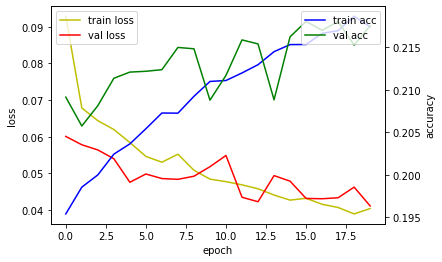

In [13]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [14]:
Atrous_unet_model_path = os.getenv("HOME")+'/Cloud_data/cloud_model/seg_atrous_unet_model_sliding800_aug_class4_epoch20_hist.h5'    
Atrous_unet_model.save(Atrous_unet_model_path)  #학습한 모델을 저장해 주세요.

---
Load model

In [10]:
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=5)]

In [11]:
# newmodel = load_model(os.getenv("HOME")+'/Cloud_data/cloud_model/seg_atrous_unet_model_sliding800_class4_epoch20_final.h5')
# newmodel.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

# with tf.device("/device:GPU:0"):
#     newmodel.fit_generator(
#          generator=train_generator,
#          validation_data=test_generator,
#          steps_per_epoch=len(train_generator),
#          epochs=40,callbacks=callbacks
#      )

/home/mjy0992/ENTER/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
1551/1551 [==============================] - 1370s 861ms/step - loss: 0.0343 - val_loss: 0.0422
Epoch 2/40
1551/1551 [==============================] - 1334s 860ms/step - loss: 0.0314 - val_loss: 0.0511
Epoch 3/40
1551/1551 [==============================] - 1336s 861ms/step - loss: 0.0336 - val_loss: 0.0471
Epoch 4/40
1551/1551 [==============================] - 1336s 862ms/step - loss: 0.0300 - val_loss: 0.0445
Epoch 5/40
1551/1551 [==============================] - 1337s 862ms/step - loss: 0.0279 - val_loss: 0.0669
Epoch 6/40
1551/1551 [==============================] - 1336s 861ms/step - loss: 0.0300 - val_loss: 0.0587


In [12]:
# newmodel_savepath = os.getenv("HOME")+'/Cloud_data/cloud_model/seg_atrous_unet_model_sliding800_class4_epoch60.h5'
# newmodel.save(newmodel_savepath)  #학습한 모델을 저장해 주세요.